In [1]:
from LRU_class import LRU as lru
from torchaudio.datasets import SPEECHCOMMANDS
import os
from pathlib import Path
from typing import Optional, Tuple, Union

import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import sys
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.


In [4]:
train_set = SubsetSC("training")
test_set = SubsetSC("testing")
valid_set = SubsetSC("validation")

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


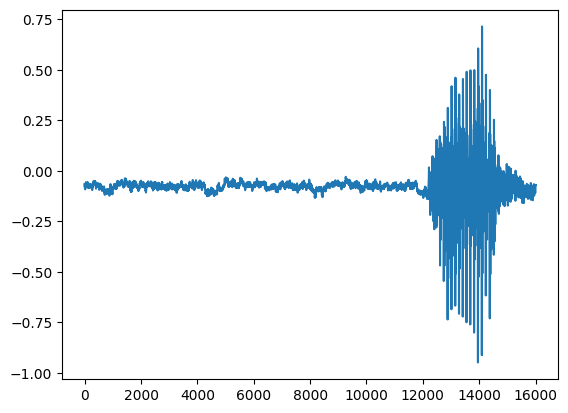

In [6]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [7]:
labels = list(set(datapoint[2] for datapoint in train_set))
labels

['dog',
 'four',
 'up',
 'wow',
 'learn',
 'zero',
 'five',
 'bed',
 'house',
 'happy',
 'three',
 'left',
 'seven',
 'cat',
 'visual',
 'backward',
 'one',
 'no',
 'down',
 'marvin',
 'follow',
 'two',
 'off',
 'yes',
 'go',
 'eight',
 'nine',
 'on',
 'tree',
 'bird',
 'forward',
 'six',
 'sheila',
 'stop',
 'right']

In [8]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [9]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(23) --> yes


In [10]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
valid_loader = torch.utils.data.DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [23]:
def train(loader, model, optimizer, epoch, cuda, verbose=True):
    model.train()
    train_loss = 0
    correct = 0
    Loss = []
    acc = []
    loop = tqdm(enumerate(loader), total = len(loader))
    for index, (data, target) in loop:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        prediction = model(data)
        prediction = torch.mean(prediction, dim = 2)
        print(prediction)
        print(target)
        train_loss = F.nll_loss(prediction, target, reduction='sum')
        pred = prediction.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        batchsize=prediction.shape[0]
        Loss.append(train_loss/batchsize)
        acc.append(correct / ((index+1)*batchsize))
        loop.set_description(f'Epoch [{epoch}/{epoch}]')
        loop.set_postfix(loss = train_loss/batchsize, correct = correct / ((index+1)*batchsize))
    loss = torch.tensor(Loss)
    acc = torch.tensor(acc)
    if not os.path.isdir('loss'):
        os.mkdir('loss')
    torch.save(loss,'./loss/epochl_{}'.format(epoch))
    torch.save(acc,'./loss/epocha_{}'.format(epoch))
    return train_loss/batchsize

def test(loader, model, cuda, verbose=True):
    model.eval()
    test_loss=0
    correct=0
    loop = tqdm(enumerate(loader), total =len(loader))
    for index, (data, target) in loop:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum')
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        loop.set_description(f'Test: ')
        loop.set_postfix(loss = test_loss/(index+1), correct = correct/(index+1))
    test_loss /= len(loader.dataset)
    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(loader.dataset), 100. * correct / len(loader.dataset)))
    return test_loss

In [24]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([256, 1, 16000])
Labels batch shape: torch.Size([256])


In [ ]:
cuda_device = False
epochs = 5
model = lru(train_features.size()[-1], batch_size)
lr = 1e-3

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(epochs):
    train(train_loader, model, optimizer, epoch, cuda_device)
    vaild_loss = test(valid_loader, model, cuda_device)
    if vaild_loss > best_valid_loss:
        iteration += 1
        print('Loss was not improved, iteration {0}'.format(str(iteration)))
    else:
        print('Saving model...')
        iteration = 0
        best_valid_loss = vaild_loss
        state = {
            'net' : model.module if cuda_device else model,
            'acc' : vaild_loss,
            'epoch' : epoch
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, 'checkpoint_'+str(epoch))
    epoch += 1

test(test_loader, model, cuda_device)